# 2020-07-23 Progress Report 

## Contents
1. Development of a Dashboard for data wrangling
2. Implementation of online classifications into ROS and existing navigation stack
3. Preliminary testing of online classifications

## Dashboard Development
The Dashboard is a python module that allows for the management, analysis and visualization of data gathered from the Myhal Simulation during SLAM testing.

### Functionality

#### Run Management
The user interacts with a `Dashboard()` object:


In [32]:
# this setup is for jupyter lab and is not nessecary when using IPython directly
%matplotlib inline
from src.dashboard import *


D = Dashboard() # optionally we can specify the verbosity of the output messages. default is logger.INFO

INFO - Loading run metadata
INFO - Writing to run_data.json
INFO - Loaded and updated metadata in 0.00 s


We can list the valid runs present in the experiment folder: ~/raid/Myhal_Simulation/simulated_runs/.

In [33]:
D.list_runs() # by default, we only list the 10 most recent runs (if there are 10 available)

  Index  Name                 Filtering Status    Classification Method    Tour Name    Success Status    Localization Method    Scenarios                  Localization Test
-------  -------------------  ------------------  -----------------------  -----------  ----------------  ---------------------  -------------------------  -------------------
      0  2020-07-20-12-18-40  false               none                     short_test   true              amcl                   empty                      false
      1  2020-07-18-18-37-52  false               none                     E_tour       true              gmapping               no_tables_wanderer_crowd,  false
                                                                                                                                 empty
      2  2020-07-18-18-37-28  true                ground_truth             E_tour       true              gmapping               no_tables_wanderer_crowd,  false
                             

We can obtain information on a specific run by index or date:

In [34]:
D.run_info('2020-07-17-12-47-30')

Name                 Filtering Status    Classification Method    Tour Name    Success Status    Localization Method    Scenarios    Localization Test
-------------------  ------------------  -----------------------  -----------  ----------------  ---------------------  -----------  -------------------
2020-07-17-12-47-30  false               none                     A_tour       true              amcl                   empty        false


Some directories in the experimental folder to not consitute valid runs (malformed or missing data). We can list all folders and their validity.

In [35]:
D.list_dirs()

Name                 Is Valid Run
-------------------  --------------
2020-07-18-18-37-52  true
2020-07-20-12-18-40  true
2020-07-18-18-37-28  true
2020-07-17-13-39-30  true
2020-07-18-18-36-45  true
2020-07-17-12-47-30  true
2020-07-12-18-04-52  false


Any old directories can be deleted (not without first being prompted for confirmation).

In [36]:
#D.remove_dir('2020-07-12-18-04-52')

#### Data Visualization and Analysis
In order to visualize data, first the user must specify what data they want to see. This is done by adding `Series()` objects to the `Dashboard()`. Series represent a set of runs adhering to various characteristics. Currently available characteristics include:
- time ranges (earliest date, latest date, exact date)
- index ranges (min index, max index, exact index)
- filtering status
- classification method
- tour name
- success status
- localization method
- scenarios present during the test 
- whether or not the run was a *localization test* or not 

The user must name the series, and has the option to choose it's colors.
The directories corrisponding to the runs of a given series can also be deleted with `remove_series_dirs()` which allows for a user to clean runs based on a certain charateristic (usually used for removing runs from before a certain date).

In [37]:
# Create a set of series that used E_tour to compare online predictions and ground truth classifications against a control
D.add_series('Online Classification', tour_names = 'E_tour', class_method = 'online_predictions') 
D.add_series('Ground Truth Classification', tour_names = 'E_tour', class_method = 'ground_truth')
D.add_series('No Classification', tour_names = 'E_tour', class_method = 'none')

The user must also choose what type of plot(s) that they want to show on the dashboard. Currently available plot types include:
- Translation Error
- Yaw Error 
- Trajectory Plot (a top down view of the robots path)
- Path Difference (the % path length difference between the robots path and the optimal path)
- Success Rate (the % of tours in the given series that succeeded) 

When a given series has many different runs, plotting them all individually can become unintelligible. Thus plots can also aggregate all of the runs for a given series (this feature is not yet available for trajectory plots)

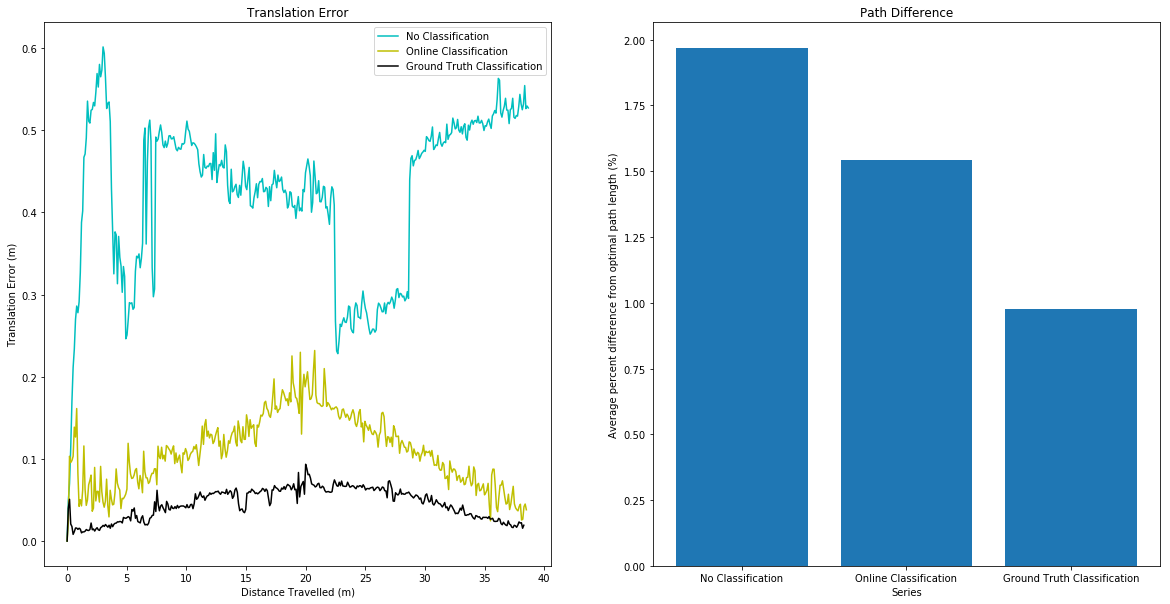

In [38]:
plt.rcParams['figure.figsize'] = [20, 10] # these resize statements are only so that Jupyter complies
D.resize(1,2) # resize the distpay such that it has one row and two columns
D.add_plot(TranslationError(aggregate = True))
D.add_plot(PathDifference(aggregate = True))
D.show()

We can add more plot types, and the display will automatically re-size to fit them.

INFO - Adding row to display to accept plot


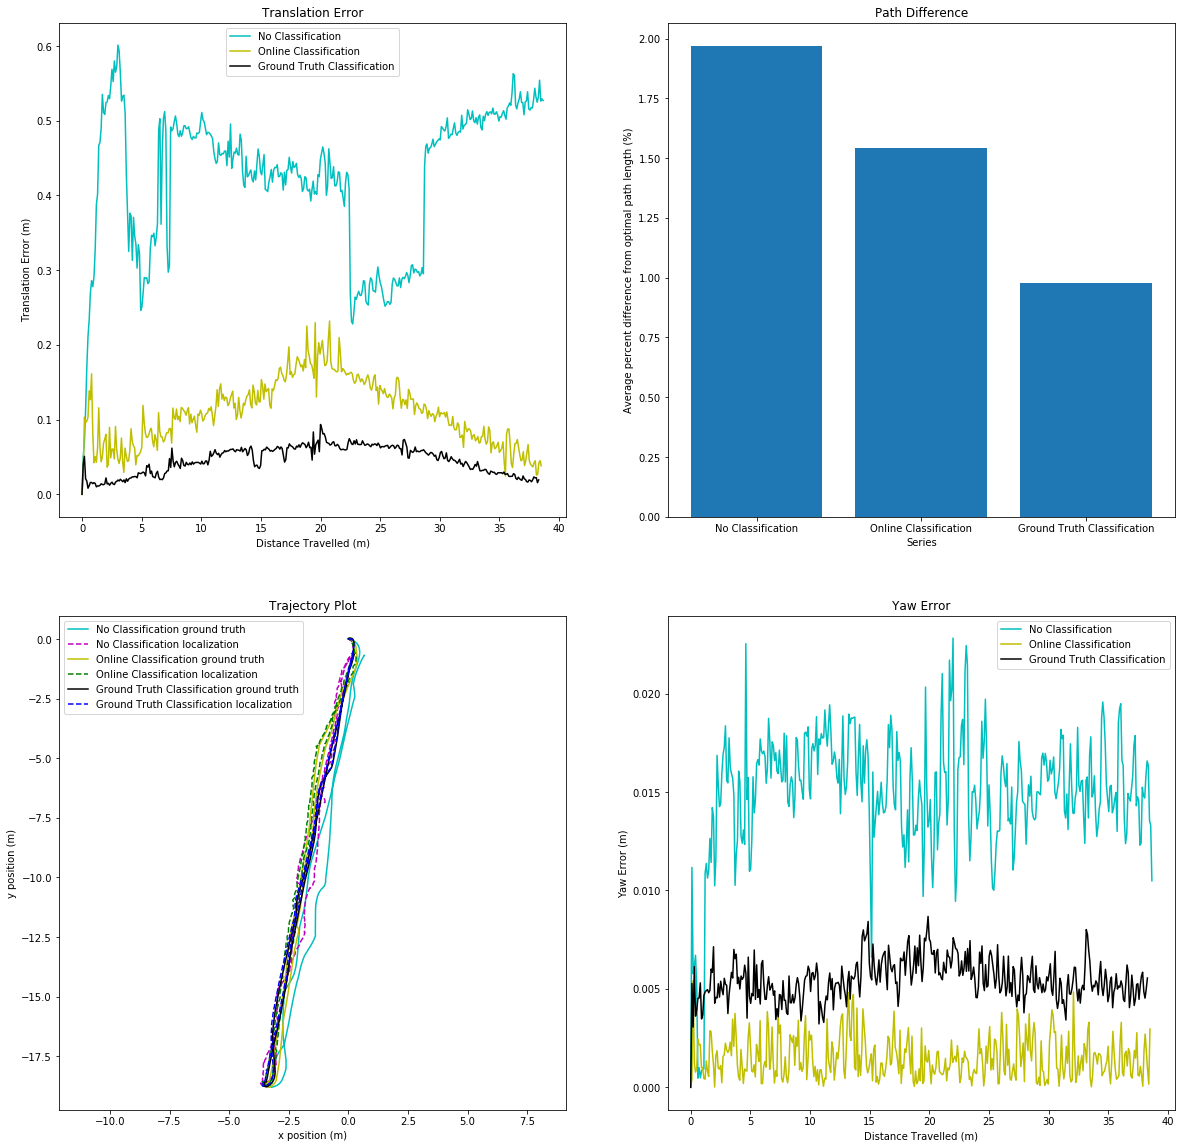

In [39]:
D.add_plot(TrajectoryPlot())
D.add_plot(YawError(aggregate = True))
plt.rcParams['figure.figsize'] = [20, 20]
D.show()

Textual information about each plot can also be displayed:

In [40]:
D.plot_info(TranslationError)
D.plot_info(YawError)
D.plot_info(PathDifference)

TranslationError: 
Series: No Classification has an average translation error of 0.423 m
Series: Online Classification has an average translation error of 0.110 m
Series: Ground Truth Classification has an average translation error of 0.046 m

YawError: 
Series: No Classification has an average yaw error of 0.01502 rad
Series: Online Classification has an average yaw error of 0.00149 rad
Series: Ground Truth Classification has an average yaw error of 0.00548 rad

PathDifference: 
Series: No Classification has a path that deviates 1.968 % from the optimal path
Series: Online Classification has a path that deviates 1.544 % from the optimal path
Series: Ground Truth Classification has a path that deviates 0.977 % from the optimal path



We note here that plotting the trajectories of multiple runs at once is confusing and not very informative. Thus, we also have the option to plot individual runs for any given plot type.

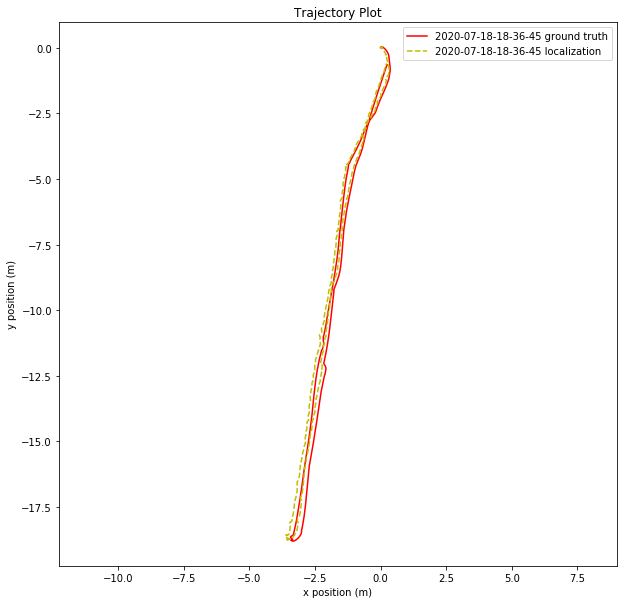

<src.dashboard.src.run_handler.TrajectoryPlot instance at 0x7f5fe4fc9f50>

In [41]:
plt.rcParams['figure.figsize'] = [10,10]
D.plot_run(3, TrajectoryPlot(True)) # once again we can specify and index or a date

Note that the function returns a plot object such that information about it can be printed. 

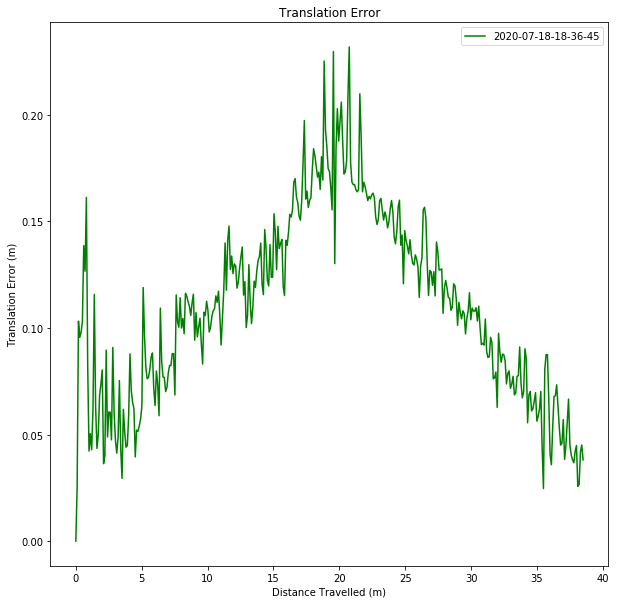

Series: 2020-07-18-18-36-45 has an average translation error of 0.110 m



In [42]:
print D.plot_run(3, TranslationError(True)).info()

Lets try a run with a more interesting tour:

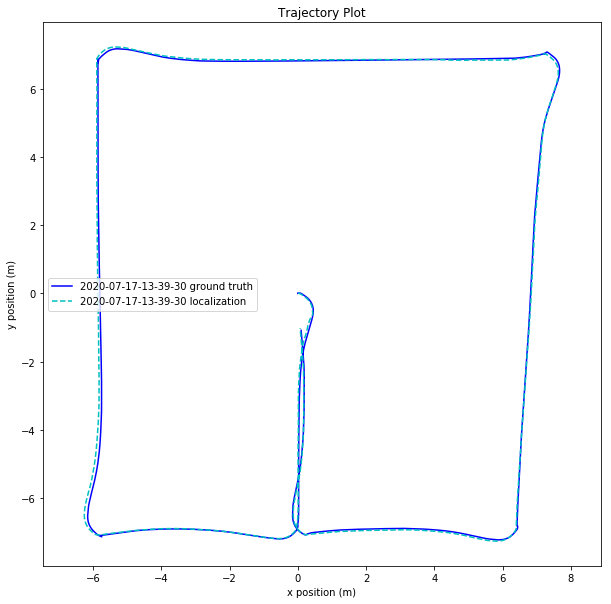

<src.dashboard.src.run_handler.TrajectoryPlot instance at 0x7f5fec2548c0>

In [43]:
D.plot_run('2020-07-17-13-39-30', TrajectoryPlot(True)) 

The dashboard also has the ability to remove and replace plots and series:

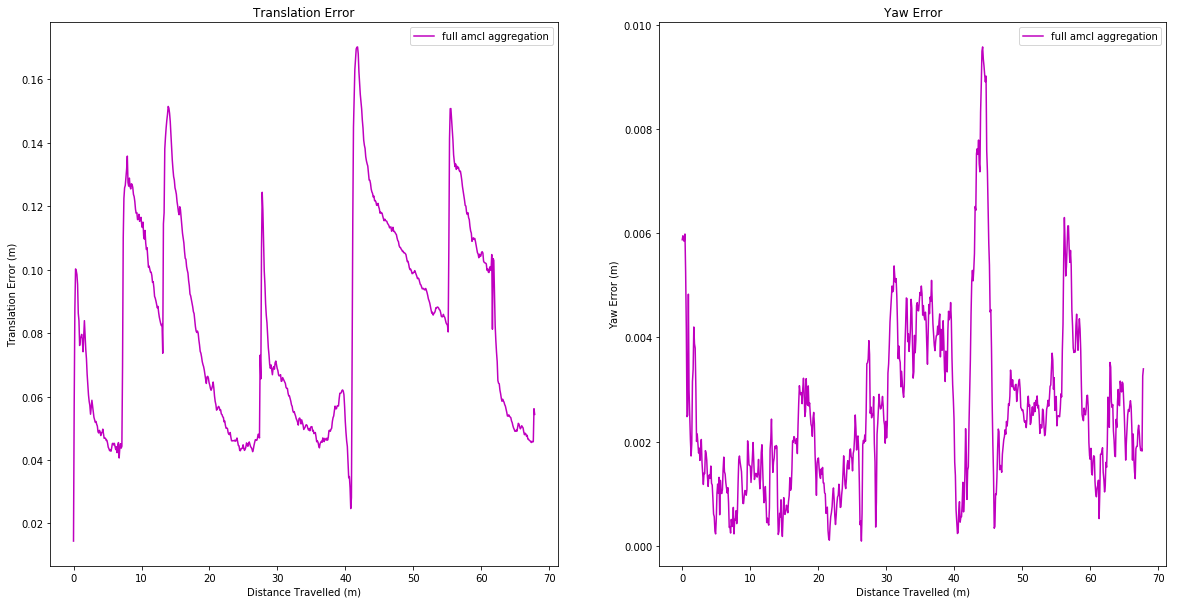

In [44]:
D.clear_series()
D.remove_plot(TrajectoryPlot)
D.remove_plot(PathDifference)
D.resize(1,2)
D.add_series('full amcl aggregation', localization_technique = 'amcl')
plt.rcParams['figure.figsize'] = [20, 10]
D.show()

The dashboard can allow for more insight on a particular run through the `visualize_run()` function. This will play the bag file of the run along with a pre-configured RVIZ file such that you can watch the run. 

In [45]:
#D.visualize_run(0, rate = 1.5) # this will play back the run at 1.5x speed (see video)

#### Future Additions 
- sorting the listed runs by a user defined attribute (other than recency)
- adding an option to automattically save the plots to a certain folder 
- improving the RVIZ config file for visualizing runs 
    - specific color mappings to point classes
    - variations dependent on scenario
- **open to suggestions and feedback**

## Online Classifications 
Online classifications have been implemented in ROS Noetic and integrated into the existing navigation stack. 

#### Preliminary Testing 
While the network is not fully trained, and the code has yet to be optimized for this application, we have gathered some preliminary test results.

## List of Available Functions for the Dashboard

In [46]:
Dashboard?

Init signature: Dashboard(self, verbosity=20, rows=1, cols=1)
Docstring:      An interface between the user and Myhal Simulation data 
Init docstring:
Optional arguments
verbosity: specified the level of logging to STOUT, logging.DEBUG, logging.INFO, logging.WARNING ..., default = logging.INFO
rows: the number of rows on the plot display, default = 1
cols: the number of columns on the plot display, default = 1
File:           ~/catkin_ws/src/dashboard/src/run_handler.py
Type:           classobj


In [47]:
Dashboard.list_runs?

Signature: Dashboard.list_runs(self, num=10)
Docstring: displays meta data for the num most recent runs 
File:      ~/catkin_ws/src/dashboard/src/run_handler.py
Type:      instancemethod


In [48]:
Dashboard.list_dirs?

Signature: Dashboard.list_dirs(self)
Docstring: list all directories in the experimental folder and whether or not they are a valid run 
File:      ~/catkin_ws/src/dashboard/src/run_handler.py
Type:      instancemethod


In [49]:
Dashboard.add_series?

Signature: Dashboard.add_series(self, name, colors=None, tour_names=None, filter_status=None, localization_technique=None, success_status=None, scenarios=None, earliest_date=None, latest_date=None, localization_test=None, class_method=None, load_world=None, date=None, min_ind=None, max_ind=None, ind=None)
Docstring: adds a series to the dashboard, where all runs in the series adhere to all specified parameters
File:      ~/catkin_ws/src/dashboard/src/run_handler.py
Type:      instancemethod


In [50]:
Dashboard.add_plot?

Signature: Dashboard.add_plot(self, plot)
Docstring: add a plot to the dashboard 
File:      ~/catkin_ws/src/dashboard/src/run_handler.py
Type:      instancemethod


In [51]:
Dashboard.remove_series?

Signature: Dashboard.remove_series(self, name)
Docstring: remove named series from dashboard 
File:      ~/catkin_ws/src/dashboard/src/run_handler.py
Type:      instancemethod


In [52]:
Dashboard.remove_plot?

Signature: Dashboard.remove_plot(self, plot_class)
Docstring: remove the given plot class from the dashboard 
File:      ~/catkin_ws/src/dashboard/src/run_handler.py
Type:      instancemethod


In [53]:
Dashboard.clear_series?

Signature: Dashboard.clear_series(self)
Docstring: remove all series from the dashboard 
File:      ~/catkin_ws/src/dashboard/src/run_handler.py
Type:      instancemethod


In [54]:
Dashboard.clear_plots?

Signature: Dashboard.clear_plots(self)
Docstring: remove all plots from the dashboard 
File:      ~/catkin_ws/src/dashboard/src/run_handler.py
Type:      instancemethod


In [55]:
Dashboard.clear?

Signature: Dashboard.clear(self)
Docstring: remove all plots and series 
File:      ~/catkin_ws/src/dashboard/src/run_handler.py
Type:      instancemethod


In [56]:
Dashboard.resize?

Signature: Dashboard.resize(self, rows, cols)
Docstring: resizes the display of this dashboard 
File:      ~/catkin_ws/src/dashboard/src/run_handler.py
Type:      instancemethod


In [57]:
Dashboard.show?

Signature: Dashboard.show(self, save=False, path='.')
Docstring: show current display as a plot, save the plot to path if given 
File:      ~/catkin_ws/src/dashboard/src/run_handler.py
Type:      instancemethod


In [58]:
Dashboard.visualize_run?

Signature: Dashboard.visualize_run(self, name_or_ind, rate=1)
Docstring: play the bag file of the named run with a pre-configured rviz file 
File:      ~/catkin_ws/src/dashboard/src/run_handler.py
Type:      instancemethod


In [59]:
Dashboard.remove_dir?

Signature: Dashboard.remove_dir(self, name)
Docstring: remove names directory from experiments folder if it exists 
File:      ~/catkin_ws/src/dashboard/src/run_handler.py
Type:      instancemethod


In [60]:
Dashboard.remove_series_dir?

Object `Dashboard.remove_series_dir` not found.


In [61]:
Dashboard.plot_run?

Signature: Dashboard.plot_run(self, name_or_ind, plot_type, colors=None, save=False, filepath='.')
Docstring: plot the named run with the given plot type (not on the display), return the plot
File:      ~/catkin_ws/src/dashboard/src/run_handler.py
Type:      instancemethod


In [62]:
Dashboard.plot_info?

Signature: Dashboard.plot_info(self, plot_class)
Docstring: return textual information about the desired plot type 
File:      ~/catkin_ws/src/dashboard/src/run_handler.py
Type:      instancemethod
